# The Quantum Random Number Generator

In [1]:
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumRegister, ClassicalRegister, execute
from qiskit import QuantumCircuit, execute, Aer
from qiskit.tools.jupyter import *
import matplotlib.pyplot as plt
import numpy as np
from math import pi
%matplotlib inline

# The Mapping Function
We define a function which takes the output of our quantum circuit and maps it into a specified range, as provided by the user.

In [2]:
def real_map(value, leftMin, leftMax, rightMin, rightMax):
    # Maps one range to another
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

# The basic Quantum Random Number generator
Now we define a very basic quantum random number generator, and the process of random number generation can be explained as:  

* Create a quantum circuit with (at least three) a few qubits, add the classical registers.  


* Add a hadamard gate on each of the qubits, making the final state an equal superposition of all the available states.  


* Do a measurement with 'statevector_simulator' and find the final state of the circuit.  


* We can have $2^n$ unique states and the final result will be a random number out of those states.

In [20]:
# Quantum Random Number generator
def QRandom(a, b, qubits):
    q = QuantumRegister(qubits, 'q')
    circ = QuantumCircuit(q)
    c0 = ClassicalRegister(1, 'c0')
    circ.add_register(c0)

    for i in range(qubits):
        circ.h(q[i])

    for i in range(qubits):
        circ.measure(q[i], c0)

    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    output = result.get_statevector(circ, decimals=5)

    n1 = 0
    n2 = 0
    n3 = 0
    for i in range( output.size ):
        if abs(output[i]) != 0:
            n1 = i
            n2 = np.real(output[i])
            n3 = np.imag(output[i])
    
    y = real_map(n1+n2+n3, -qubits, len(output)-1+qubits, a, b) 
    return y

# Generating random numbers with our Quantum RNG

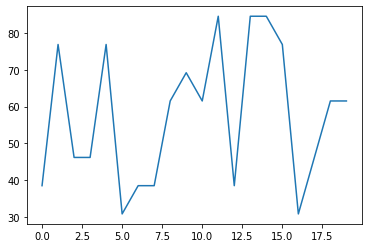

In [21]:
y = []
for i in range(20):
    y.append(QRandom(0,100,3))
    
plt.plot(y)

# The problems with this Quantum RNG:
While this preliminary quantum RNG does look promising, it has a lot of problems inherently:  

* The total number of unique random numbers it can generate is at max $2^n$, hence if one requires a large number of unique random numbers, this RNG will fail.  

* The qubit requirement will be huge even for a small number of unique random numbers.  

* Patterns and repititions start appearing at certain points.   

* Time and memory requirements might be an issue.


In [22]:
# Example of number of unique random numbers:

# Generating 40 random numbers with our QRNG

y = []
for i in range(40):
    y.append(QRandom(0,100,3))

count = 0

z=[]

#Counting the number of unique elements

for num in y:
    if num not in z:
        count = count+1
        z.append(num)
print('The number of unique elements in provided random distribution is:')
print(count)

The number of unique elements in provided random distribution is:
8


# Our Solution: A Variatonal Circuit 

To tackle the problems with this basic quantum RNG, we propose a variational quantum circuit, which can help us generate a wider range of random numbers.

The process in this variational quantum RNG can be broken down into:  

* We include a couple of rotations, one along y-axis and one along x-axis, providing us a change in configuration and a change in phase, hence allowing us to create a much better range of random numbers.  

* We provide a certain depth to the circuit as well, just to make sure we can provide large variations to the circuit.

In [23]:
def VarQRandom(a, b, theta, depth, qubits):
    # Quantum Random Number generator
    q = QuantumRegister(qubits, 'q')
    circ = QuantumCircuit(q)
    c0 = ClassicalRegister(2, 'c0')
    circ.add_register(c0)
    
    for j in range(depth):
        
        for i in range(qubits):
            circ.h(q[i])
            circ.ry(theta, q[i])
            circ.rx(theta, q[i])

    for i in range(qubits):
        circ.measure(q[i], c0)

    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    output = result.get_statevector(circ, decimals=5)

    n1 = 0
    n2 = 0
    n3 = 0
    for i in range( output.size ):
        if abs(output[i]) != 0:
            n1 = i
            n2 = np.real(output[i])
            n3 = np.imag(output[i])
    
    y = real_map(n1+n2+n3, -qubits, len(output)-1+qubits, a, b)
    return y